# Predicting Heart Disease

**Authors: Elnaz Azizi, Charly Watts, Christian Unterrainer**

## 1. Introduction & Objective

This notebook aims to predict the presence of heart disease using machine learning techniques. We will be working with subsets of the **UCI Heart Disease Dataset**, specifically the data from:
1.  Cleveland Clinic Foundation
2.  Swiss University Hospital, Basel/Zurich
3.  Hungarian Institute of Cardiology, Budapest

These datasets are commonly used benchmarks for this classification task.

**Objective:**
The primary goal is to build, evaluate, and compare several classification models:
1. Logistic Regression (Baseline)
2. K-Nearest Neighbors (KNN) (Baseline)
3. Gaussian Naive Bayes (Baseline)
4. Gradient Boosting Classifier
5. MLP Classifier (Neural Network)
6. Random Forest Classifier
7. Support Vector Machine (SVM) Classifier

We will employ appropriate data preprocessing steps, including imputation and scaling. Model evaluation will focus on the F1-score for the positive class (presence of heart disease). Two main evaluation strategies will be explored:
- **Nested Cross-Validation:** To obtain a robust estimate of model generalization performance.
- **Train/Test Split with GridSearchCV & Threshold Optimization:** To identify a specific "best" model configuration and optimize its decision threshold for the F1-score.

The notebook will walk through data loading, preprocessing, model pipeline definition, evaluation, and visualization of the results.

## 2. Imports

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, f1_score, auc
from IPython.display import display
from xgboost import XGBClassifier 

## 3. Data Loading and Initial Preparation

### 3.1. Load Data from Files
We load three processed datasets originating from the UCI Heart Disease repository: Cleveland, Switzerland, and Hungarian. Missing values are denoted by '?' in the raw files. The Hungarian dataset is space-separated, while the others are comma-separated.

In [19]:
file_info = [
    ('data/processed.cleveland.data', False),
    ('data/processed.switzerland.data', False),
    ('data/reprocessed.hungarian.data', True),  # space-separated
]
col_names = [
    'age','sex','cp','trestbps','chol','fbs',
    'restecg','thalach','exang','oldpeak',
    'slope','ca','thal','target'
]
dataframes = []
df_names = ['Cleveland', 'Switzerland', 'Hungarian'] 
for path, is_space_separated in file_info:
    if is_space_separated:
        df = pd.read_csv(path, sep=r'\s+', header=None, names=col_names, na_values='?')
    else:
        df = pd.read_csv(path, header=None, names=col_names, na_values='?')
    dataframes.append(df)

### 3.2. Initial Data Inspection (Brief)

In [20]:
for df_name, df in zip(df_names, dataframes):
    print(f"\n--- {df_name} Dataset Info ---")
    df.info()
    print(f"\n--- Missing Values in {df_name} (Count) ---")
    print(df.isnull().sum())


--- Cleveland Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB

--- Missing Values in Cleveland (Count) ---
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
sl

## 4. Data Preparation for Modeling

### 4.1. Target Variable Transformation and Train-Test Split
The target variable is binarized (0: no disease, 1: presence of disease). Data is then split into stratified training and testing sets. Proportions are printed to 4 decimal places for readability.

In [21]:
splits = []
for df, (path, _) in zip(dataframes, file_info):
    dataset_name_from_path = path.split('/')[-1] 
    df['target'] = df['target'].astype(int).apply(lambda v: 1 if v > 0 else 0)
    x = df.drop(columns='target')
    y = df['target']
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y 
    )
    splits.append({
        "dataset": dataset_name_from_path,
        "x_train": x_train, "x_test": x_test,
        "y_train": y_train, "y_test": y_test
    })
    print(f"\n--- Target distribution in {dataset_name_from_path} (Binarized) ---")
    original_dist = {k: f'{v:.4f}' for k, v in y.value_counts(normalize=True).sort_index().to_dict().items()}
    train_dist = {k: f'{v:.4f}' for k, v in y_train.value_counts(normalize=True).sort_index().to_dict().items()}
    test_dist = {k: f'{v:.4f}' for k, v in y_test.value_counts(normalize=True).sort_index().to_dict().items()}
    print(f"Original: {original_dist}")
    print(f"Train:    {train_dist}")
    print(f"Test:     {test_dist}")


--- Target distribution in processed.cleveland.data (Binarized) ---
Original: {0: '0.5413', 1: '0.4587'}
Train:    {0: '0.5413', 1: '0.4587'}
Test:     {0: '0.5410', 1: '0.4590'}

--- Target distribution in processed.switzerland.data (Binarized) ---
Original: {0: '0.0650', 1: '0.9350'}
Train:    {0: '0.0612', 1: '0.9388'}
Test:     {0: '0.0800', 1: '0.9200'}

--- Target distribution in reprocessed.hungarian.data (Binarized) ---
Original: {0: '0.6395', 1: '0.3605'}
Train:    {0: '0.6383', 1: '0.3617'}
Test:     {0: '0.6441', 1: '0.3559'}


### 4.2. Feature Column Configuration

In [22]:
numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

### 4.3. Preprocessing Pipeline Definition
Numeric features are imputed with the median and scaled. Categorical features are imputed with the most frequent value, and an indicator for imputation is added.

In [23]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True))
])
preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_cols),
    ('cat', cat_pipe, categorical_cols)
])

## 5. Modeling Pipeline Definition

### 5.1. Full Model Pipelines
Pipelines are defined for each classifier, integrating the preprocessor. `random_state` is set for reproducibility where applicable.

In [24]:
logistic_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42)) 
])
kneighbors_pipeline = Pipeline([
    ('pre', preprocessor),
    ('knn', KNeighborsClassifier())
])
naive_pipeline = Pipeline([
    ('pre', preprocessor),
    ('nav', GaussianNB())
])
gradient_boosting_pipeline = Pipeline([
    ('pre', preprocessor),
    ('gbc', GradientBoostingClassifier(random_state=42))
])
mlp_pipeline = Pipeline([
    ('pre', preprocessor),
    ('mlp', MLPClassifier(random_state=42, max_iter=1000)) 
])
rf_pipeline = Pipeline([
    ('pre', preprocessor),
    ('rf', RandomForestClassifier(random_state=42))
])
svm_pipeline = Pipeline([
    ('pre', preprocessor),
    ('svc', SVC(random_state=42, probability=True))
])

xgb_pipeline = Pipeline([
    ('pre', preprocessor),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

### 5.2. Hyperparameter Grids
Hyperparameter search spaces are defined for each model (except Naive Bayes). Grids are kept relatively small for manageable runtimes.

In [25]:
logistic_param_grid = {
    'clf__C': [0.01, 0.1, 1, 10]  # Inverse of regularization strength; smaller values specify stronger regularization.
}
kneighbors_param_grid = {
    'knn__n_neighbors': list(range(1, 21))  # Number of neighbors to use.
}
naive_param_grid = {}  # No significant hyperparameters for GaussianNB to tune in this context.

gradient_boosting_param_grid = {
    'gbc__n_estimators': [100, 200],        # Number of boosting stages (trees) to run.
    'gbc__learning_rate': [0.05, 0.1],     # Step size shrinkage used in update to prevent overfitting.
    'gbc__max_depth': [3, 5],                  # Maximum depth of the individual regression estimators (trees).
    'gbc__subsample': [0.8],                 # Fraction of samples to be used for fitting individual base learners.
    'gbc__min_samples_split': [5],         # Minimum number of samples required to split an internal node.
    'gbc__min_samples_leaf': [3]           # Minimum number of samples required to be at a leaf node.
}

mlp_param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100, 50)], # Tuple, ith element is number of neurons in ith hidden layer.
    'mlp__activation': ['relu'],                   # Activation function for the hidden layer ('relu', 'tanh', 'logistic').
    'mlp__solver': ['adam'],                       # The solver for weight optimization ('adam', 'sgd', 'lbfgs').
    'mlp__alpha': [0.001, 0.01],                   # L2 penalty (regularization term) parameter.
    'mlp__learning_rate_init': [0.001],            # The initial learning rate used.
    'mlp__early_stopping': [True],                 # Whether to use early stopping to terminate training when validation score is not improving.
    'mlp__n_iter_no_change': [10]                  # Number of iterations with no improvement to wait before stopping.
}

rf_param_grid = {
    'rf__n_estimators' : [100, 200],              # The number of trees in the forest.
    'rf__max_depth' : [None, 10, 20],             # The maximum depth of the tree. If None, nodes expanded until all leaves are pure or contain less than min_samples_split.
    'rf__min_samples_split' : [2, 5],             # The minimum number of samples required to split an internal node.
    'rf__min_samples_leaf' : [1, 2],              # The minimum number of samples required to be at a leaf node.
    'rf__class_weight': ['balanced', None]         # Weights associated with classes ('balanced', 'balanced_subsample', or None).
}

svm_param_grid = {
    'svc__C': [0.1, 1, 10],                       # Regularization parameter. Strength is inversely proportional to C.
    'svc__kernel': ['linear', 'rbf'],              # Specifies the kernel type to be used in the algorithm ('linear', 'poly', 'rbf', 'sigmoid').
    'svc__gamma': ['scale', 'auto', 0.1]           # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'. 'scale' and 'auto' are good defaults.
}

xgb_param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__subsample': [0.8, 1],
    'xgb__colsample_bytree': [0.8, 1]
}

### 5.3. Model Configurations Dictionary
A dictionary mapping model names to their pipelines and hyperparameter grids for streamlined evaluation.

In [26]:
model_configurations = {
    "Logistic Regression": (logistic_pipeline, logistic_param_grid),
    "K Nearest Neighbors": (kneighbors_pipeline, kneighbors_param_grid),
    "Naive Bayes": (naive_pipeline, naive_param_grid),
    "Gradient Boosting": (gradient_boosting_pipeline, gradient_boosting_param_grid),
    "MLP Classifier": (mlp_pipeline, mlp_param_grid),
    "Random Forest": (rf_pipeline, rf_param_grid),
    "SVM Classifier": (svm_pipeline, svm_param_grid),
    "XGBoost" : (xgb_pipeline, xgb_param_grid)
}

## 6. Model Evaluation Strategies

### 6.1. Nested Cross-Validation for Robust Performance Estimation
Nested CV provides a less biased estimate of model generalization performance. The outer loop evaluates, while the inner loop tunes hyperparameters. F1-score is the primary metric.

In [27]:
nested_cv_results_summary = []

for split_data in splits: 
    dataset_name = split_data["dataset"]
    # print(f"Running Nested CV for dataset: {dataset_name}") # Removed for cleaner output

    X_full = pd.concat([split_data["x_train"], split_data["x_test"]], ignore_index=True)
    y_full = pd.concat([split_data["y_train"], split_data["y_test"]], ignore_index=True)

    for model_name, (pipeline, param_grid) in model_configurations.items():
        # print(f"  Model: {model_name}") # Removed for cleaner output
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) 
        grid_search_cv = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='f1', n_jobs=-1)
        outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
        nested_f1_scores = cross_val_score(grid_search_cv, X_full, y_full, cv=outer_cv, scoring='f1', n_jobs=-1)

        nested_cv_results_summary.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Nested F1 Mean": nested_f1_scores.mean(),
            "Nested F1 Std": nested_f1_scores.std()
        })

nested_cv_df = pd.DataFrame(nested_cv_results_summary)
print("\n--- Nested Cross-Validation Results Summary ---")
# Pivoted table for better readability, dataset as index, model as columns
nested_cv_pivot_df = nested_cv_df.pivot_table(index="Dataset", columns="Model", values="Nested F1 Mean").round(4)
display(nested_cv_pivot_df)

[14:15:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[14:15:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[14:15:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[14:15:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[14:15:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[14:15:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[14:15:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[14:15:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" }


--- Nested Cross-Validation Results Summary ---


Model,Gradient Boosting,K Nearest Neighbors,Logistic Regression,MLP Classifier,Naive Bayes,Random Forest,SVM Classifier,XGBoost
Dataset,,,,,,,,
processed.cleveland.data,0.7580,0.7681,0.7776,0.6890,0.6995,0.7873,0.7876,0.7788
processed.switzerland.data,0.9485,0.9665,0.9665,0.9526,0.6654,0.9576,0.9665,0.9706
reprocessed.hungarian.data,0.6925,0.7187,0.7434,0.6875,0.6793,0.7254,0.7407,0.7030


### 6.2. Train/Test Split with GridSearchCV & Threshold Optimization
This "Threshold Optimization Approach" tunes hyperparameters on the training set (optimizing for 'recall' in GridSearchCV), predicts probabilities on the test set, and then optimizes the decision threshold to maximize F1-score on the test set.

In [28]:
detailed_classic_results = [] 

for split_data in splits:
    dataset_name = split_data["dataset"]
    x_train = split_data["x_train"]
    y_train = split_data["y_train"]
    x_test = split_data["x_test"]
    y_test = split_data["y_test"]
    # print(f"\nRunning Threshold Optimization for dataset: {dataset_name}") # Removed for cleaner output

    for model_name, (pipeline, param_grid) in model_configurations.items():
        # print(f"  Model: {model_name}") # Removed for cleaner output
        grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='recall', n_jobs=-1) # cv=3 for speed
        grid.fit(x_train, y_train)

        y_probs = grid.predict_proba(x_test)[:, 1]

        precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_probs)
        f1_scores_pr = 2 * (precisions * recalls) / (precisions + recalls + 1e-10) 
        
        if len(f1_scores_pr) > len(thresholds_pr):
             best_idx_pr = np.argmax(f1_scores_pr[:-1]) 
        else:
             best_idx_pr = np.argmax(f1_scores_pr)
        
        best_threshold = thresholds_pr[best_idx_pr]
        
        y_pred = (y_probs >= best_threshold).astype(int)

        report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        cm = confusion_matrix(y_test, y_pred)

        detailed_classic_results.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Best Estimator": grid.best_estimator_,
            "Best Params (from GridSearchCV)": grid.best_params_,
            "Optimized Threshold": best_threshold, # Stored as float
            "Recall (Class 1, Opt Thresh)": report_dict.get('1', {}).get('recall', 0),
            "Precision (Class 1, Opt Thresh)": report_dict.get('1', {}).get('precision', 0),
            "F1-Score (Class 1, Opt Thresh)": report_dict.get('1', {}).get('f1-score', 0),
            "Confusion Matrix": cm,
            "y_test": y_test,
            "y_probs": y_probs,
            "y_pred_optimized_thresh": y_pred,
            "precisions_pr": precisions, 
            "recalls_pr": recalls,       
            "f1_scores_pr": f1_scores_pr 
        })

threshold_optimization_summary_list = []
for res in detailed_classic_results:
    threshold_optimization_summary_list.append({
        "Dataset": res["Dataset"],
        "Model": res["Model"],
        "F1-Score (Optimized Threshold)": res["F1-Score (Class 1, Opt Thresh)"],
        "Optimized Threshold": res["Optimized Threshold"] # Keep as float for pivoting
    })
threshold_optimization_df_summary = pd.DataFrame(threshold_optimization_summary_list)

print("\n--- Threshold Optimization Approach Results Summary ---")
display(threshold_optimization_df_summary.pivot_table(
    index=['Dataset', 'Model'], 
    values=['F1-Score (Optimized Threshold)', 'Optimized Threshold']
).round(4))

/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:17:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:17:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:17:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:17:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



--- Threshold Optimization Approach Results Summary ---


/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:17:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:17:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:17:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:17:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


F1-Score (Optimized Threshold)  \
Dataset                    Model                                                 
processed.cleveland.data   Gradient Boosting                            0.9259   
                           K Nearest Neighbors                          0.7586   
                           Logistic Regression                          0.9091   
                           MLP Classifier                               0.6292   
                           Naive Bayes                                  0.8438   
                           Random Forest                                0.9000   
                           SVM Classifier                               0.8525   
                           XGBoost                                      0.8966   
processed.switzerland.data Gradient Boosting                            0.9583   
                           K Nearest Neighbors                          0.9583   
                           Logistic Regression                          0.9583   
                           MLP Classifier                               0.9583   
                           Naive Bayes                                  0.9583   
                           Random Forest                                0.9583   
                           SVM Classifier                               0.9583   
                           XGBoost                                      0.9583   
reprocessed.hungarian.data Gradient Boosting                            0.7692   
                           K Nearest Neighbors                          0.8095   
                           Logistic Regression                          0.8500   
                           MLP Classifier                               0.8571   
                           Naive Bayes                                  0.8182   
                           Random Forest                                0.8108   
                           SVM Classifier                               0.7170   
                           XGBoost                                      0.7692   

                                                Optimized Threshold  
Dataset                    Model                                     
processed.cleveland.data   Gradient Boosting                 0.8093  
                           K Nearest Neighbors               0.6667  
                           Logistic Regression               0.6517  
                           MLP Classifier                    0.2877  
                           Naive Bayes                       0.0000  
                           Random Forest                     0.4801  
                           SVM Classifier                    0.5347  
                           XGBoost                           0.7081  
processed.switzerland.data Gradient Boosting                 0.0046  
                           K Nearest Neighbors               0.6000  
                           Logistic Regression               0.9309  
                           MLP Classifier                    0.5264  
                           Naive Bayes                       0.0000  
                           Random Forest                     0.5600  
                           SVM Classifier                    0.9259  
                           XGBoost                           0.7668  
reprocessed.hungarian.data Gradient Boosting                 0.5983  
                           K Nearest Neighbors               0.6000  
                           Logistic Regression               0.4642  
                           MLP Classifier                    0.4411  
                           Naive Bayes                       0.2865  
                           Random Forest                     0.6447  
                           SVM Classifier                    0.2167  
                           XGBoost                           0.7632

## 7. Results Visualization and Comparison

### 7.1. Tabular F1-Score Comparison (All Models - Nested CV vs. Threshold Optimization)

In [29]:
thresh_opt_df_for_plot = pd.DataFrame([{
    "Dataset": res["Dataset"], 
    "Model": res["Model"], 
    "F1-Score": res["F1-Score (Class 1, Opt Thresh)"]} 
    for res in detailed_classic_results])
thresh_opt_df_for_plot["Type"] = "Threshold Optimization"

nested_df_for_plot = nested_cv_df.copy()
nested_df_for_plot.rename(columns={"Nested F1 Mean": "F1-Score"}, inplace=True)
nested_df_for_plot["Type"] = "Nested CV"

combined_f1_df_for_comparison = pd.concat([
    thresh_opt_df_for_plot[["Dataset", "Model", "F1-Score", "Type"]],
    nested_df_for_plot[["Dataset", "Model", "F1-Score", "Type"]]
], ignore_index=True)

print("\n--- F1 Score Comparison: Nested CV vs. Threshold Optimization (All Models) ---")
pivot_table_f1_all_models = combined_f1_df_for_comparison.pivot_table(
    index=["Dataset", "Model"], 
    columns="Type", 
    values="F1-Score"
).round(4)
display(pivot_table_f1_all_models)


--- F1 Score Comparison: Nested CV vs. Threshold Optimization (All Models) ---


Type                                            Nested CV  \
Dataset                    Model                            
processed.cleveland.data   Gradient Boosting       0.7580   
                           K Nearest Neighbors     0.7681   
                           Logistic Regression     0.7776   
                           MLP Classifier          0.6890   
                           Naive Bayes             0.6995   
                           Random Forest           0.7873   
                           SVM Classifier          0.7876   
                           XGBoost                 0.7788   
processed.switzerland.data Gradient Boosting       0.9485   
                           K Nearest Neighbors     0.9665   
                           Logistic Regression     0.9665   
                           MLP Classifier          0.9526   
                           Naive Bayes             0.6654   
                           Random Forest           0.9576   
                           SVM Classifier          0.9665   
                           XGBoost                 0.9706   
reprocessed.hungarian.data Gradient Boosting       0.6925   
                           K Nearest Neighbors     0.7187   
                           Logistic Regression     0.7434   
                           MLP Classifier          0.6875   
                           Naive Bayes             0.6793   
                           Random Forest           0.7254   
                           SVM Classifier          0.7407   
                           XGBoost                 0.7030   

Type                                            Threshold Optimization  
Dataset                    Model                                        
processed.cleveland.data   Gradient Boosting                    0.9259  
                           K Nearest Neighbors                  0.7586  
                           Logistic Regression                  0.9091  
                           MLP Classifier                       0.6292  
                           Naive Bayes                          0.8438  
                           Random Forest                        0.9000  
                           SVM Classifier                       0.8525  
                           XGBoost                              0.8966  
processed.switzerland.data Gradient Boosting                    0.9583  
                           K Nearest Neighbors                  0.9583  
                           Logistic Regression                  0.9583  
                           MLP Classifier                       0.9583  
                           Naive Bayes                          0.9583  
                           Random Forest                        0.9583  
                           SVM Classifier                       0.9583  
                           XGBoost                              0.9583  
reprocessed.hungarian.data Gradient Boosting                    0.7692  
                           K Nearest Neighbors                  0.8095  
                           Logistic Regression                  0.8500  
                           MLP Classifier                       0.8571  
                           Naive Bayes                          0.8182  
                           Random Forest                        0.8108  
                           SVM Classifier                       0.7170  
                           XGBoost                              0.7692

### 7.1.1. Identifying the Best Performing Baseline Model
We select the best baseline (Logistic Regression, KNN, Naive Bayes) by considering both its robust Nested CV F1 Mean and its performance in the Threshold Optimization approach. This chosen baseline will be used for focused comparison against advanced models.

In [30]:
baseline_model_names = ["Logistic Regression", "K Nearest Neighbors", "Naive Bayes"]
advanced_model_names = ["Gradient Boosting", "MLP Classifier", "Random Forest", "SVM Classifier", "XGBoost"]

# --- 1. Analysis based on Nested CV F1 Mean for Baselines ---
baseline_nested_cv_results_df = nested_cv_df[nested_cv_df['Model'].isin(baseline_model_names)]
print("\n--- Performance of Baseline Models (Nested CV F1 Mean) ---")
baseline_pivot_nested = baseline_nested_cv_results_df.pivot_table(
    index="Dataset", columns="Model", values="Nested F1 Mean"
).round(4)
display(baseline_pivot_nested)
print("-" * 70)

avg_nested_f1_baselines = baseline_nested_cv_results_df.groupby('Model')['Nested F1 Mean'].mean().sort_values(ascending=False).round(4)
print("\n--- Average Nested F1 Means for Baseline Models (Ranked) ---")
if len(avg_nested_f1_baselines) <= 3:
    print(avg_nested_f1_baselines.to_string())
else:
    display(avg_nested_f1_baselines.to_frame())
print("-" * 70)

# --- 2. Analysis based on Threshold Optimization F1-Score for Baselines ---
thresh_opt_f1_scores_baselines_list = []
for res_item in detailed_classic_results: 
    if res_item['Model'] in baseline_model_names:
        thresh_opt_f1_scores_baselines_list.append({
            "Dataset": res_item["Dataset"],
            "Model": res_item["Model"],
            "F1-Score (Optimized Threshold)": res_item["F1-Score (Class 1, Opt Thresh)"] 
        })
baseline_thresh_opt_results_df = pd.DataFrame(thresh_opt_f1_scores_baselines_list)

if not baseline_thresh_opt_results_df.empty:
    print("\n\n--- Performance of Baseline Models (Threshold Optimization F1-Score) ---")
    baseline_pivot_thresh_opt = baseline_thresh_opt_results_df.pivot_table(
        index="Dataset", columns="Model", values="F1-Score (Optimized Threshold)"
    ).round(4)
    display(baseline_pivot_thresh_opt)
    print("-" * 70)

    avg_thresh_opt_f1_baselines = baseline_thresh_opt_results_df.groupby('Model')['F1-Score (Optimized Threshold)'].mean().sort_values(ascending=False).round(4)
    print("\n--- Average Threshold Optimization F1 Scores for Baseline Models (Ranked) ---")
    if len(avg_thresh_opt_f1_baselines) <=3:
        print(avg_thresh_opt_f1_baselines.to_string())
    else:
        display(avg_thresh_opt_f1_baselines.to_frame())
    print("-" * 70)
else:
    print("\nNo baseline model results found in 'detailed_classic_results' for Threshold Optimization F1 analysis.")
    avg_thresh_opt_f1_baselines = pd.Series(dtype='float64')

# --- 3. Decision for 'overall_best_baseline_name' for subsequent plots ---
overall_best_baseline_name = None
if not avg_nested_f1_baselines.empty:
    overall_best_baseline_name = avg_nested_f1_baselines.idxmax()
    best_nested_f1_score = avg_nested_f1_baselines.max()
    best_thresh_opt_f1_score = None
    if overall_best_baseline_name in avg_thresh_opt_f1_baselines.index:
        best_thresh_opt_f1_score = avg_thresh_opt_f1_baselines[overall_best_baseline_name]
    print(f"\n>>> Decision: Selected '{overall_best_baseline_name}' as the Best Baseline for focused plots. <<<")
    print(f"    Reason: Highest average Nested CV F1 Mean ({best_nested_f1_score:.4f}).")
    if best_thresh_opt_f1_score is not None:
        print(f"    Its average Threshold Optimization F1-Score is: {best_thresh_opt_f1_score:.4f}.")
else:
    print("\n>>> Warning: Could not determine an overall best baseline model from Nested CV results. <<<")

if overall_best_baseline_name:
    models_for_focused_plots = [overall_best_baseline_name] + advanced_model_names
else:
    print("Warning: No best baseline selected. Focused plots will show advanced models only.")
    models_for_focused_plots = advanced_model_names


--- Performance of Baseline Models (Nested CV F1 Mean) ---


Model,K Nearest Neighbors,Logistic Regression,Naive Bayes
Dataset,,,
processed.cleveland.data,0.7681,0.7776,0.6995
processed.switzerland.data,0.9665,0.9665,0.6654
reprocessed.hungarian.data,0.7187,0.7434,0.6793


----------------------------------------------------------------------

--- Average Nested F1 Means for Baseline Models (Ranked) ---
Model
Logistic Regression    0.8292
K Nearest Neighbors    0.8178
Naive Bayes            0.6814
----------------------------------------------------------------------


--- Performance of Baseline Models (Threshold Optimization F1-Score) ---


Model,K Nearest Neighbors,Logistic Regression,Naive Bayes
Dataset,,,
processed.cleveland.data,0.7586,0.9091,0.8438
processed.switzerland.data,0.9583,0.9583,0.9583
reprocessed.hungarian.data,0.8095,0.8500,0.8182


----------------------------------------------------------------------

--- Average Threshold Optimization F1 Scores for Baseline Models (Ranked) ---
Model
Logistic Regression    0.9058
Naive Bayes            0.8734
K Nearest Neighbors    0.8422
----------------------------------------------------------------------

>>> Decision: Selected 'Logistic Regression' as the Best Baseline for focused plots. <<<
    Reason: Highest average Nested CV F1 Mean (0.8292).
    Its average Threshold Optimization F1-Score is: 0.9058.


### 7.1.2. Selecting the Final Best Performing Model (Overall)
Considering all models (baselines and advanced), we select the overall best performing model based primarily on the average Nested CV F1 Mean for its robustness, and secondarily on the average Threshold Optimization F1 score.

In [31]:
print("\n--- Average Nested F1 Means for ALL Models (Ranked) ---")
avg_nested_f1_all_models = nested_cv_df.groupby('Model')['Nested F1 Mean'].mean().sort_values(ascending=False).round(4)
display(avg_nested_f1_all_models.to_frame())
overall_best_nested_model_name = avg_nested_f1_all_models.idxmax()
overall_best_nested_model_f1 = avg_nested_f1_all_models.max()
print(f"Best Model (Nested CV Avg F1): {overall_best_nested_model_name} (F1: {overall_best_nested_model_f1:.4f})")
print("-" * 70)

print("\n--- Average Threshold Optimization F1 Scores for ALL Models (Ranked) ---")
avg_thresh_opt_f1_all_models = threshold_optimization_df_summary.groupby('Model')['F1-Score (Optimized Threshold)'].mean().sort_values(ascending=False).round(4)
display(avg_thresh_opt_f1_all_models.to_frame())
overall_best_thresh_opt_model_name = avg_thresh_opt_f1_all_models.idxmax()
overall_best_thresh_opt_model_f1 = avg_thresh_opt_f1_all_models.max()
print(f"Best Model (Threshold Opt. Avg F1): {overall_best_thresh_opt_model_name} (F1: {overall_best_thresh_opt_model_f1:.4f})")
print("-" * 70)


--- Average Nested F1 Means for ALL Models (Ranked) ---


,Nested F1 Mean
Model,
SVM Classifier,0.8316
Logistic Regression,0.8292
Random Forest,0.8234
K Nearest Neighbors,0.8178
XGBoost,0.8174
Gradient Boosting,0.7997
MLP Classifier,0.7764
Naive Bayes,0.6814


Best Model (Nested CV Avg F1): SVM Classifier (F1: 0.8316)
----------------------------------------------------------------------

--- Average Threshold Optimization F1 Scores for ALL Models (Ranked) ---


,F1-Score (Optimized Threshold)
Model,
Logistic Regression,0.9058
Random Forest,0.8897
Gradient Boosting,0.8845
XGBoost,0.8747
Naive Bayes,0.8734
SVM Classifier,0.8426
K Nearest Neighbors,0.8422
MLP Classifier,0.8149


Best Model (Threshold Opt. Avg F1): Logistic Regression (F1: 0.9058)
----------------------------------------------------------------------


### 7.2. Focused Visualizations: Best Baseline vs. Advanced Models
Visualizations focus on comparing the chosen best baseline against advanced models using results from the Threshold Optimization approach.

#### 7.2.1. Confusion Matrices (Best Baseline vs. Advanced)

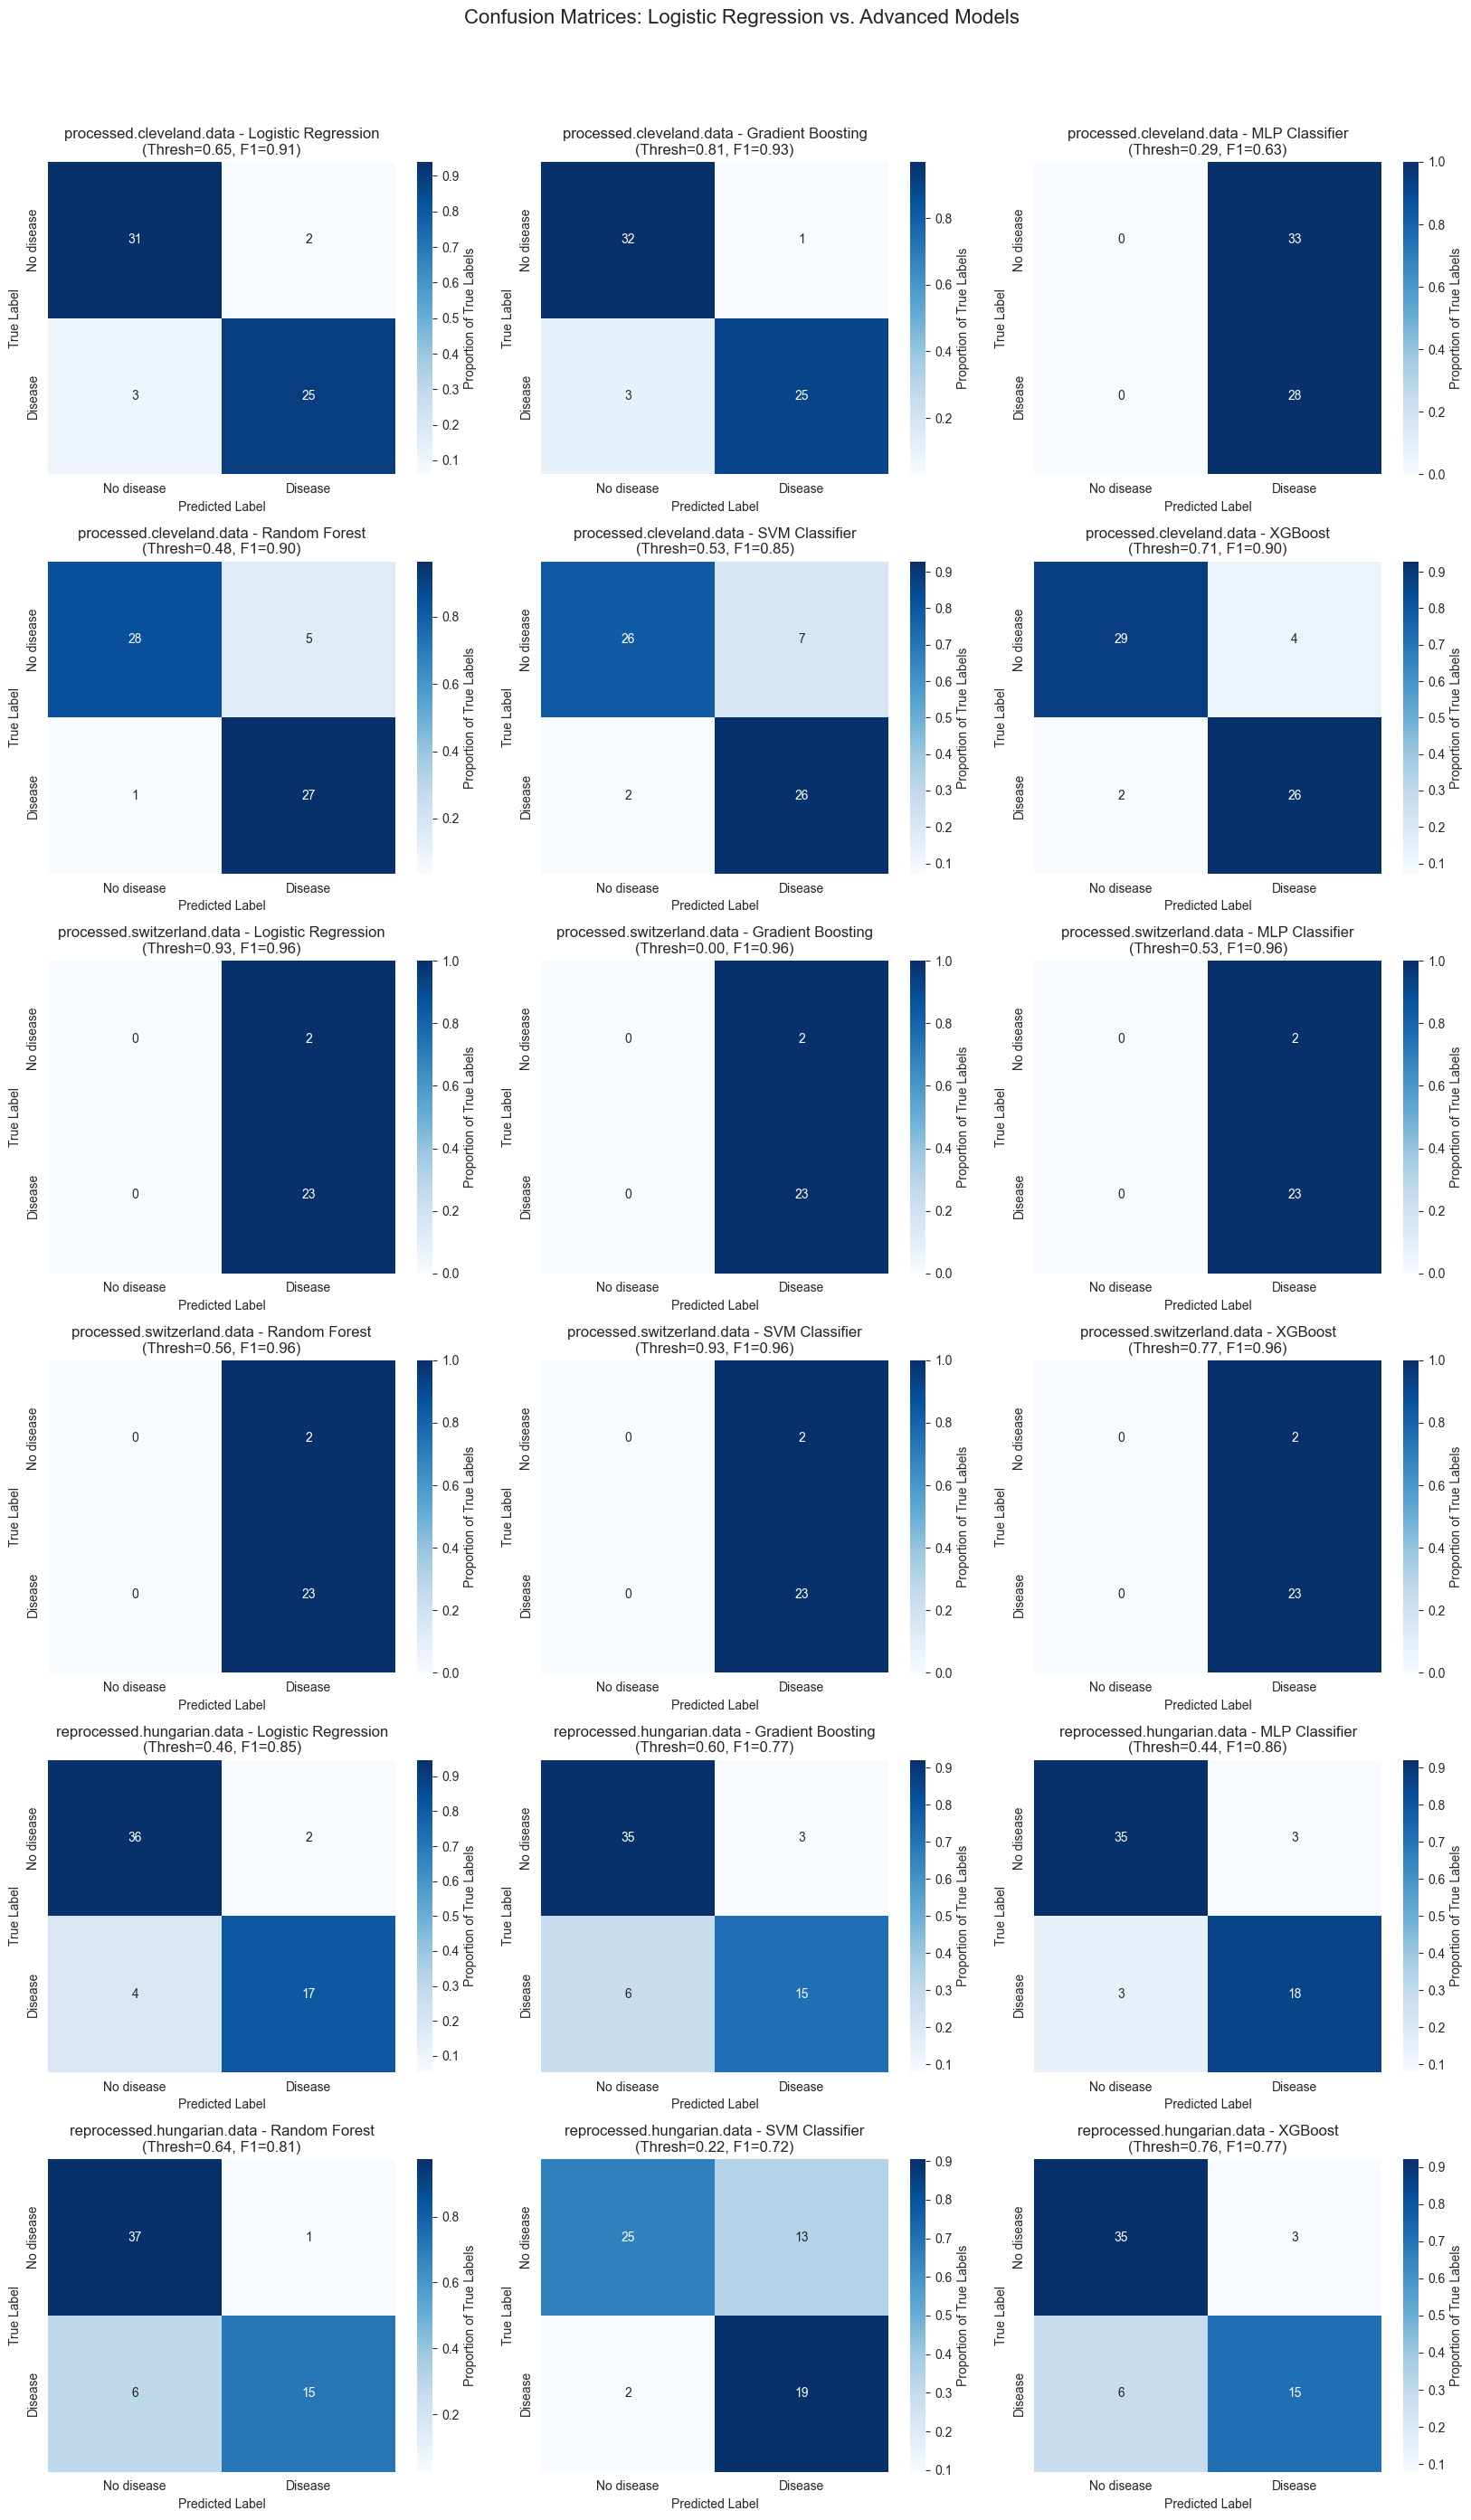

In [32]:
focused_detailed_classic_results_cm = [
    res for res in detailed_classic_results if res['Model'] in models_for_focused_plots
]
num_plots_focused_cm = len(focused_detailed_classic_results_cm)
cols_focused_cm = 3 
rows_focused_cm = math.ceil(num_plots_focused_cm / cols_focused_cm)

fig_focused_cm, axes_focused_cm = plt.subplots(rows_focused_cm, cols_focused_cm, 
                                               figsize=(cols_focused_cm * 5.5, rows_focused_cm * 4.5))
if num_plots_focused_cm == 1:
    axes_flat_focused_cm = [axes_focused_cm]
elif num_plots_focused_cm == 0:
    axes_flat_focused_cm = []
    if rows_focused_cm > 0 : fig_focused_cm.set_visible(False) 
else:
    axes_flat_focused_cm = axes_focused_cm.flatten()

for idx, res in enumerate(focused_detailed_classic_results_cm):
    ax = axes_flat_focused_cm[idx]
    cm = res["Confusion Matrix"]
    cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] 
    cm_norm = np.nan_to_num(cm_norm) 
    sns.heatmap(
        cm_norm, annot=cm, fmt='d', cmap='Blues',
        xticklabels=['No disease', 'Disease'], yticklabels=['No disease', 'Disease'],
        ax=ax, cbar=True, cbar_kws={'label': 'Proportion of True Labels'}
    )
    ax.set_title(f'{res["Dataset"]} - {res["Model"]}\n(Thresh={res["Optimized Threshold"]:.2f}, F1={res["F1-Score (Class 1, Opt Thresh)"]:.2f})')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

for i in range(num_plots_focused_cm, rows_focused_cm * cols_focused_cm):
    if num_plots_focused_cm > 0 and rows_focused_cm * cols_focused_cm > 0 and i < len(axes_flat_focused_cm): 
      fig_focused_cm.delaxes(axes_flat_focused_cm[i])

title_cm = 'Confusion Matrices: Advanced Models' 
if overall_best_baseline_name:
    title_cm = f'Confusion Matrices: {overall_best_baseline_name} vs. Advanced Models'
if num_plots_focused_cm > 0: 
    plt.suptitle(title_cm, fontsize=16, y=1.03)
    plt.tight_layout()
    plt.show()
elif rows_focused_cm == 0 and 'fig_focused_cm' in locals(): 
    plt.close(fig_focused_cm)

#### 7.2.2. Precision-Recall (P-R) Curves (Best Baseline vs. Advanced)
Each plot below shows P-R curves for different models on a specific dataset. This allows for direct comparison of model performance on that dataset. The point corresponding to the optimized F1-score is marked.

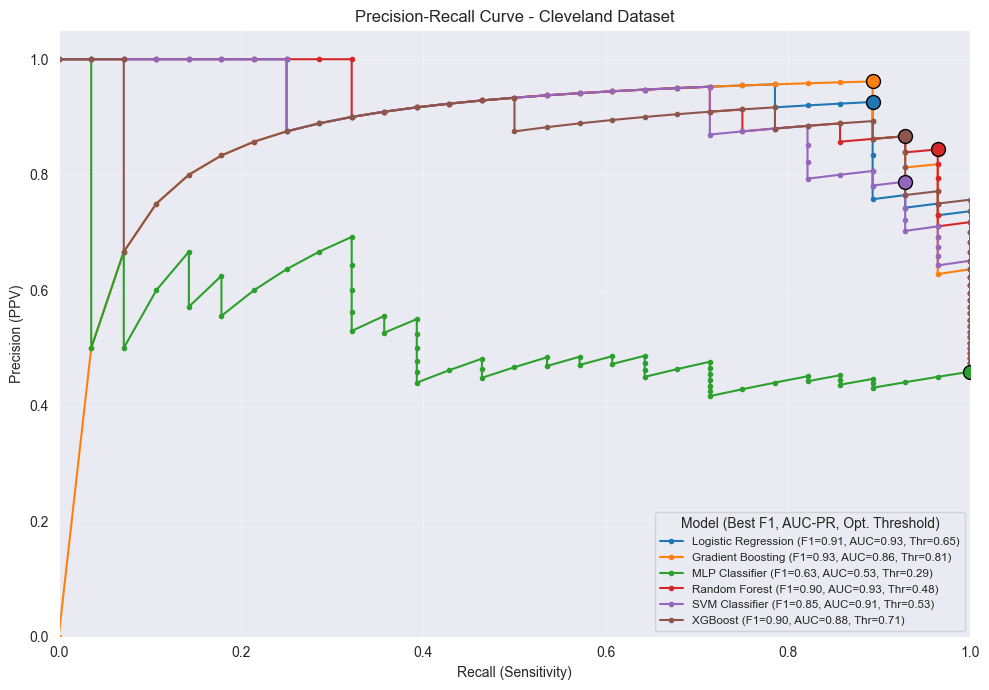

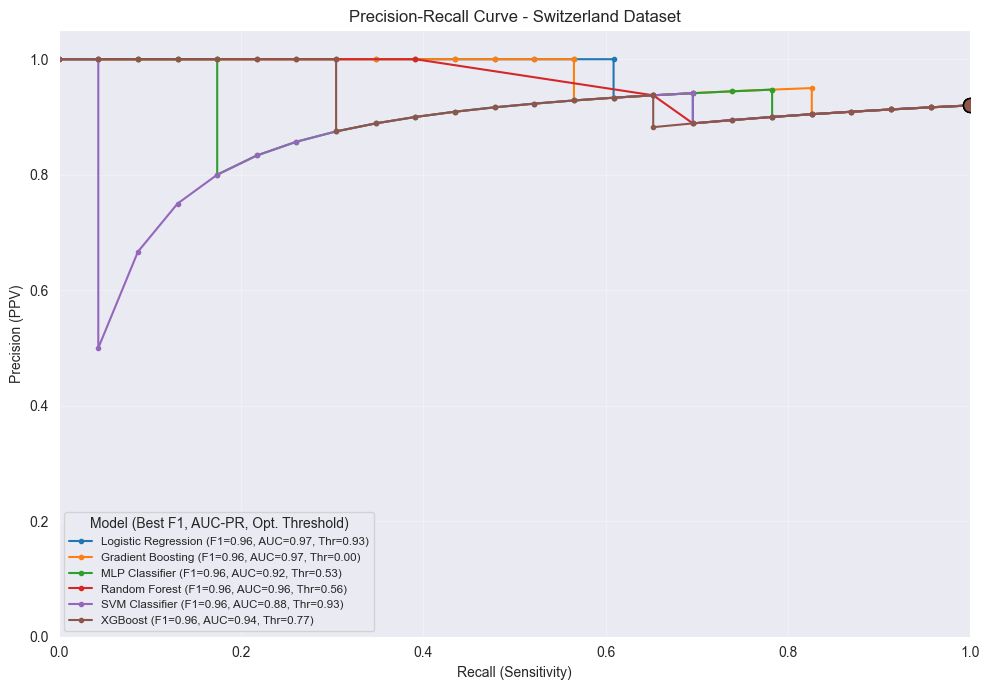

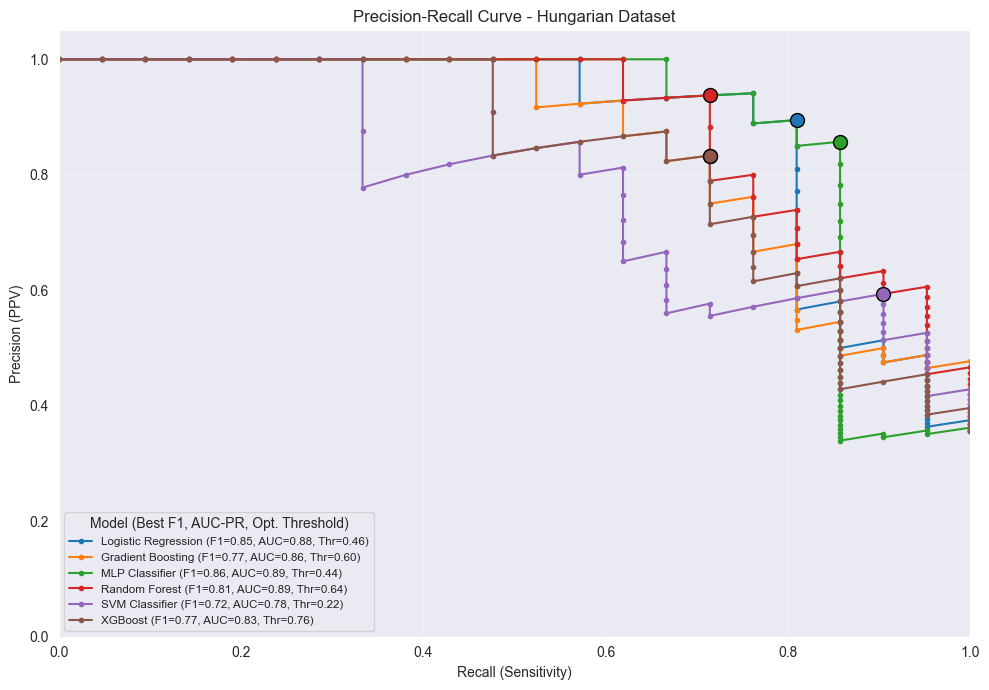

In [33]:
palette = sns.color_palette("tab10", n_colors=len(models_for_focused_plots))
model_color_map = {model: palette[i % len(palette)] for i, model in enumerate(models_for_focused_plots)}

unique_datasets = sorted(list(set(res["Dataset"] for res in detailed_classic_results)))

for dataset_name_pr in unique_datasets:
    plt.figure(figsize=(10, 7))
    results_for_this_dataset = [res for res in detailed_classic_results if res["Dataset"] == dataset_name_pr and res["Model"] in models_for_focused_plots]
    
    if not results_for_this_dataset:
        print(f"No results to plot P-R curves for dataset: {dataset_name_pr}")
        plt.close()
        continue

    for res in results_for_this_dataset:
        model_name_pr = res["Model"]
        precisions = res["precisions_pr"]
        recalls = res["recalls_pr"]
        current_f1 = res["F1-Score (Class 1, Opt Thresh)"]
        auc_pr = auc(recalls, precisions) # Calculate Area Under PR Curve
        
        # Find index for optimized threshold point on the P-R curve
        f1_options = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        if len(f1_options) > len(res.get("thresholds_pr", recalls[:-1])):
            best_idx_pr = np.argmax(f1_options[:-1])
        else:
            best_idx_pr = np.argmax(f1_options)

        plt.plot(recalls, precisions, marker='.', 
                 label=f'{model_name_pr} (F1={current_f1:.2f}, AUC={auc_pr:.2f}, Thr={res["Optimized Threshold"]:.2f})',
                 color=model_color_map.get(model_name_pr, palette[-1])) # Use mapped color
        plt.scatter(recalls[best_idx_pr], precisions[best_idx_pr], 
                    color=model_color_map.get(model_name_pr, palette[-1]), 
                    edgecolor='black', marker='o', s=100, zorder=5, label=f'_nolegend_')

    plt.title(f"Precision-Recall Curve - {dataset_name_pr.split('.')[1].capitalize()} Dataset")
    plt.xlabel("Recall (Sensitivity)")
    plt.ylabel("Precision (PPV)")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid(alpha=0.3)
    plt.legend(title="Model (Best F1, AUC-PR, Opt. Threshold)", loc="best", fontsize='small')
    plt.tight_layout()
    plt.show()

#### 7.2.3. F1-Score Comparison Bar Plots (Focused Comparison)

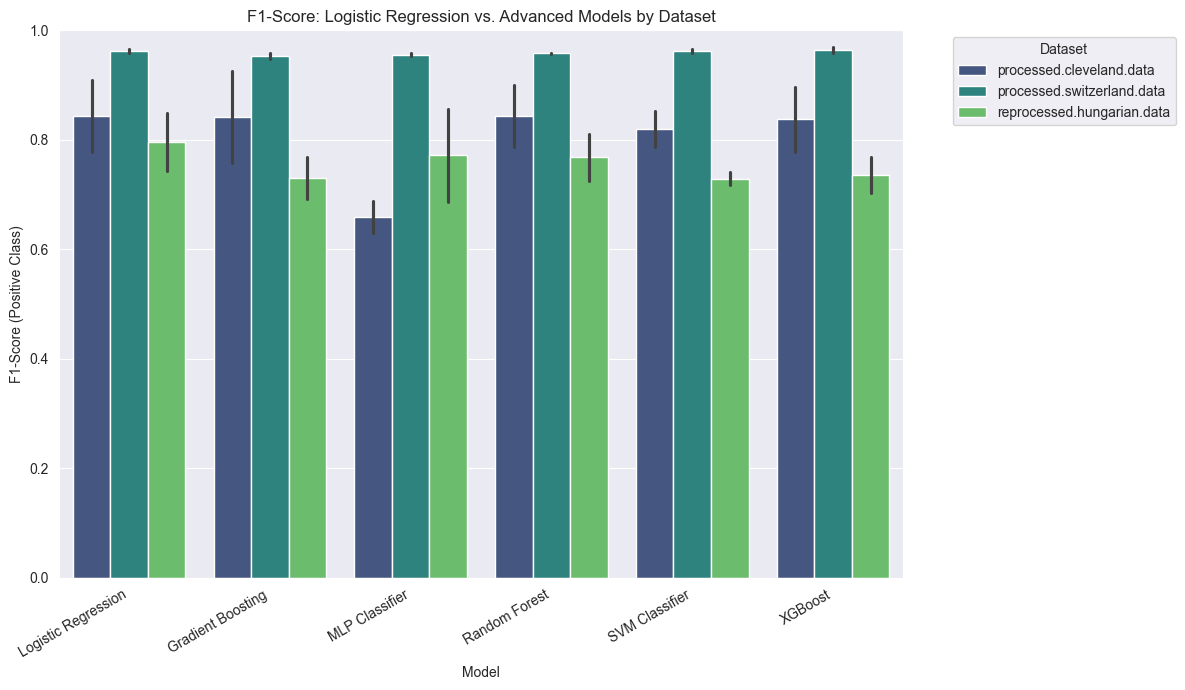

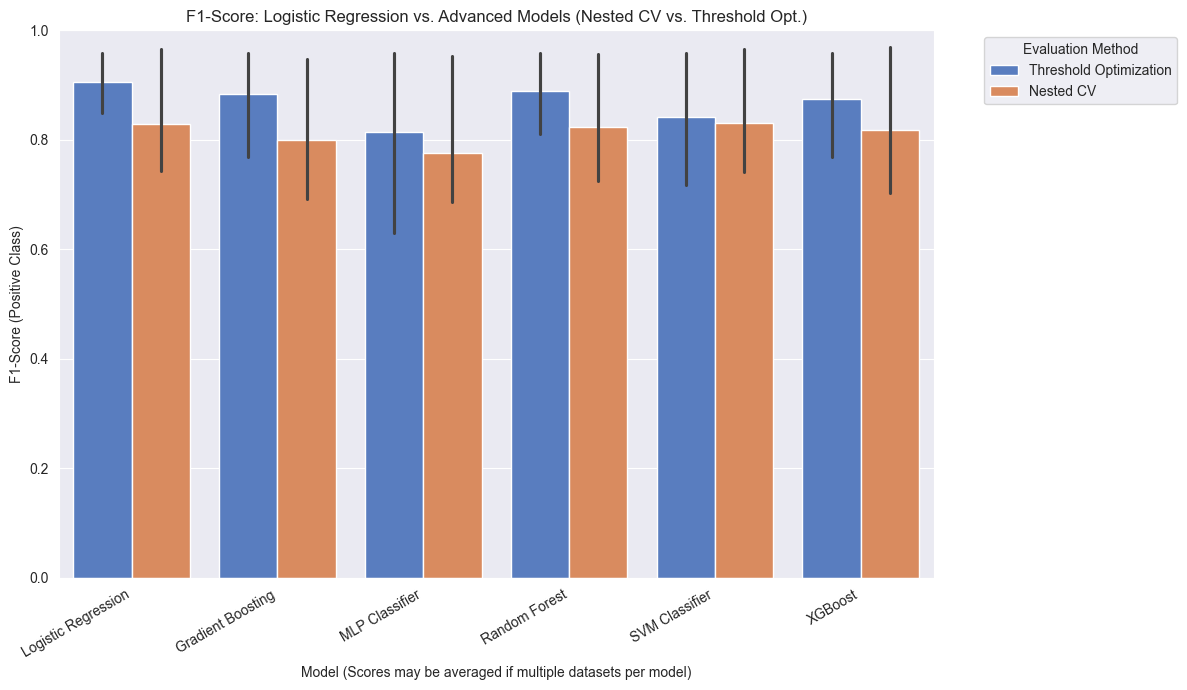

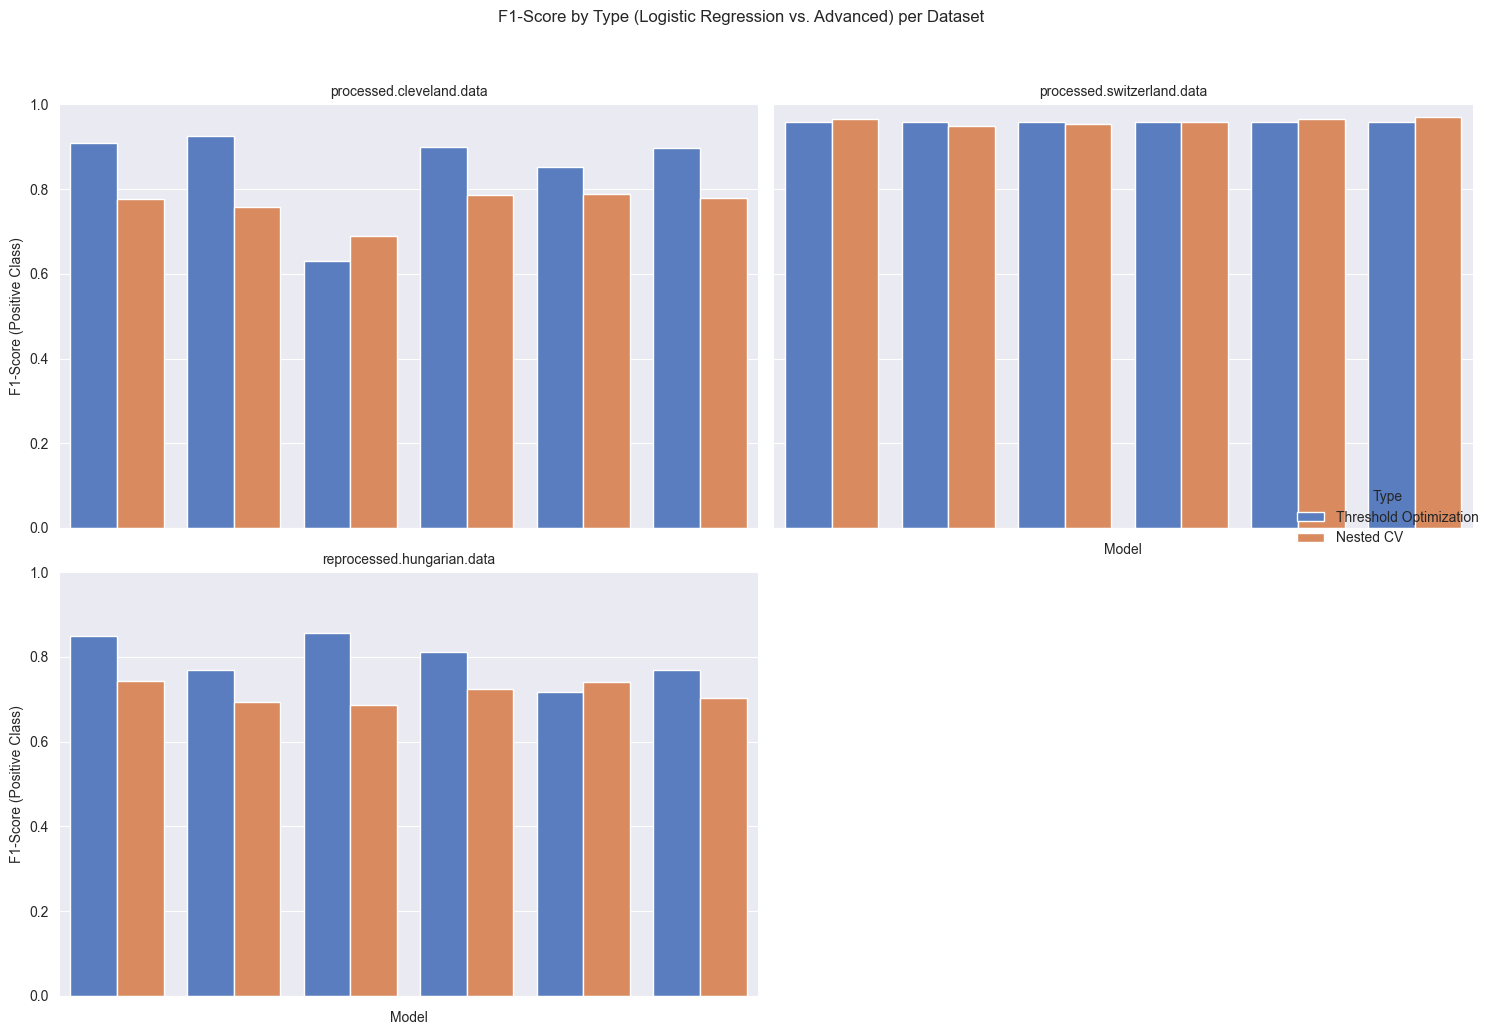

In [34]:
focused_comparison_plot_df = combined_f1_df_for_comparison[
    combined_f1_df_for_comparison['Model'].isin(models_for_focused_plots)
]

if not focused_comparison_plot_df.empty:
    title_str_dataset_hue = f"F1-Score by Dataset"
    title_str_type_hue = f"F1-Score by Eval Type"
    title_str_catplot = f"F1-Score by Type per Dataset"
    if overall_best_baseline_name:
        title_str_dataset_hue = f"F1-Score: {overall_best_baseline_name} vs. Advanced Models by Dataset"
        title_str_type_hue = f"F1-Score: {overall_best_baseline_name} vs. Advanced Models (Nested CV vs. Threshold Opt.)"
        title_str_catplot = f"F1-Score by Type ({overall_best_baseline_name} vs. Advanced) per Dataset"
    
    plt.figure(figsize=(12, 7)) 
    sns.barplot(data=focused_comparison_plot_df, x="Model", y="F1-Score", hue="Dataset", palette="viridis")
    plt.title(title_str_dataset_hue) 
    plt.ylabel("F1-Score (Positive Class)")
    plt.xlabel("Model")
    plt.ylim(0, 1)
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 7))
    sns.barplot(data=focused_comparison_plot_df, x="Model", y="F1-Score", hue="Type", palette="muted")
    plt.title(title_str_type_hue) 
    plt.ylabel("F1-Score (Positive Class)")
    plt.xlabel("Model (Scores may be averaged if multiple datasets per model)")
    plt.ylim(0, 1)
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="Evaluation Method", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    g = sns.catplot(data=focused_comparison_plot_df, x="Model", y="F1-Score", hue="Type", col="Dataset", 
                    kind="bar", palette="muted", col_wrap=2, height=5, aspect=1.3)
    g.set_titles("{col_name}")
    g.set_axis_labels("Model", "F1-Score (Positive Class)")
    g.set(ylim=(0,1))
    g.set_xticklabels(rotation=45, ha="right")
    plt.suptitle(title_str_catplot, y=1.03) 
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot for focused F1-score comparison. Check model names and filtering.")